In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.n_jobs = 6

/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.2


In [3]:
adata = sc.read_10x_mtx("../data/Ileum/", cache=True)
adata

... reading from cache file cache/..-data-Ileum-matrix.h5ad


AnnData object with n_obs × n_vars = 39671 × 33660
    var: 'gene_ids'

In [4]:
obs = pd.read_table("../data/Ileum/Effi_tsne_final.txt", header=[0, 1])
obs.columns = [i[0] for i in obs.columns]
obs.index = obs.NAME
adata = adata[obs.NAME, :]
adata.obs = obs
adata.obs

,NAME,X,Y,Primary Lineages,kmeans
NAME,,,,,
122_AAACCTGGTTCCCGAG,122_AAACCTGGTTCCCGAG,-17.523981,25.760201,IgA plasma cells,5
122_AAAGATGTCAGCTCTC,122_AAAGATGTCAGCTCTC,-4.299636,-1.107461,Tregs,2
122_AAAGCAACAAGAAGAG,122_AAAGCAACAAGAAGAG,18.438143,-1.855235,Mast cells,17
122_AAATGCCTCACCCGAG,122_AAATGCCTCACCCGAG,8.266746,4.860057,TRM,3
122_AACCATGCATCACCCT,122_AACCATGCATCACCCT,1.359606,36.710104,IgA plasma cells,10
...,...,...,...,...,...
209_TTTGTCAGTCTCTTAT,209_TTTGTCAGTCTCTTAT,11.309222,21.416638,TRM,1
209_TTTGTCAGTGTGGTTT,209_TTTGTCAGTGTGGTTT,23.971407,1.429820,Group3 ILC,13
209_TTTGTCATCAGTTAGC,209_TTTGTCATCAGTTAGC,8.514284,0.595697,TRM,3


In [5]:
adata.obsm['X_orig'] = adata.obs[['X', 'Y']]

In [6]:
adata.obs['batch'] = adata.obs.NAME.str[0:3]

In [7]:
sample_info = pd.crosstab(adata.obs['batch'], adata.obs['Primary Lineages'])
sample_info.style

Primary Lineages,ACKR1+ endothelial cells,B cells,CD36+ endothelial cells,Central Memory T cells,Cytotoxic T cells,DC1,DC2,DC2 CD206+,Fibroblasts,Glial Cells,Group1 ILC,Group3 ILC,Highly activated T cells,IgA plasma cells,IgG plasma cells,IgM plasma cells,Lymphatics,Macrophages,Mast cells,Naive T cells,Pericytes,Plasmablasts,Smooth muscle cells,T (gd),TFH-like T cells,TRM,Tregs
batch,,,,,,,,,,,,,,,,,,,,,,,,,,,
122,1,10,0,4,2,2,19,1,6,0,7,20,2,142,7,13,0,6,19,1,0,0,0,7,10,145,13
128,76,641,2,82,34,12,27,8,16,0,63,5,129,248,415,61,1,18,4,20,7,26,1,19,79,172,146
138,67,1618,2,956,191,13,5,7,6,0,38,19,74,90,299,17,7,14,8,35,15,20,5,24,56,66,178
158,6,133,15,16,73,10,78,41,13,0,26,47,14,671,18,40,2,85,9,158,2,19,7,32,212,1305,100
181,60,2690,11,33,296,13,63,11,9,1,132,26,216,765,287,40,4,47,25,1566,3,71,2,54,1042,854,461
187,99,43,4,5,6,28,34,0,12,2,14,11,61,143,203,36,0,24,3,20,6,10,3,6,12,54,53
190,12,766,43,2,77,38,58,32,56,1,29,202,17,399,37,46,9,68,3,1073,8,10,17,49,229,1217,261
193,36,1462,41,11,51,14,162,83,18,4,343,89,52,1030,121,227,5,139,13,543,26,26,2,20,853,3014,448
196,10,239,19,8,39,10,77,29,49,0,36,40,29,567,137,79,2,115,4,15,5,33,17,9,171,515,223


In [8]:
sample_info.sum(axis=1)

batch
122     437
128    2312
138    3830
158    3132
181    8782
187     892
190    4759
193    8833
196    2477
209    4109
dtype: int64

In [9]:
train_data = adata[adata.obs.batch != '193']
test_data = adata[adata.obs.batch == '193']

/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'Primary Lineages' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


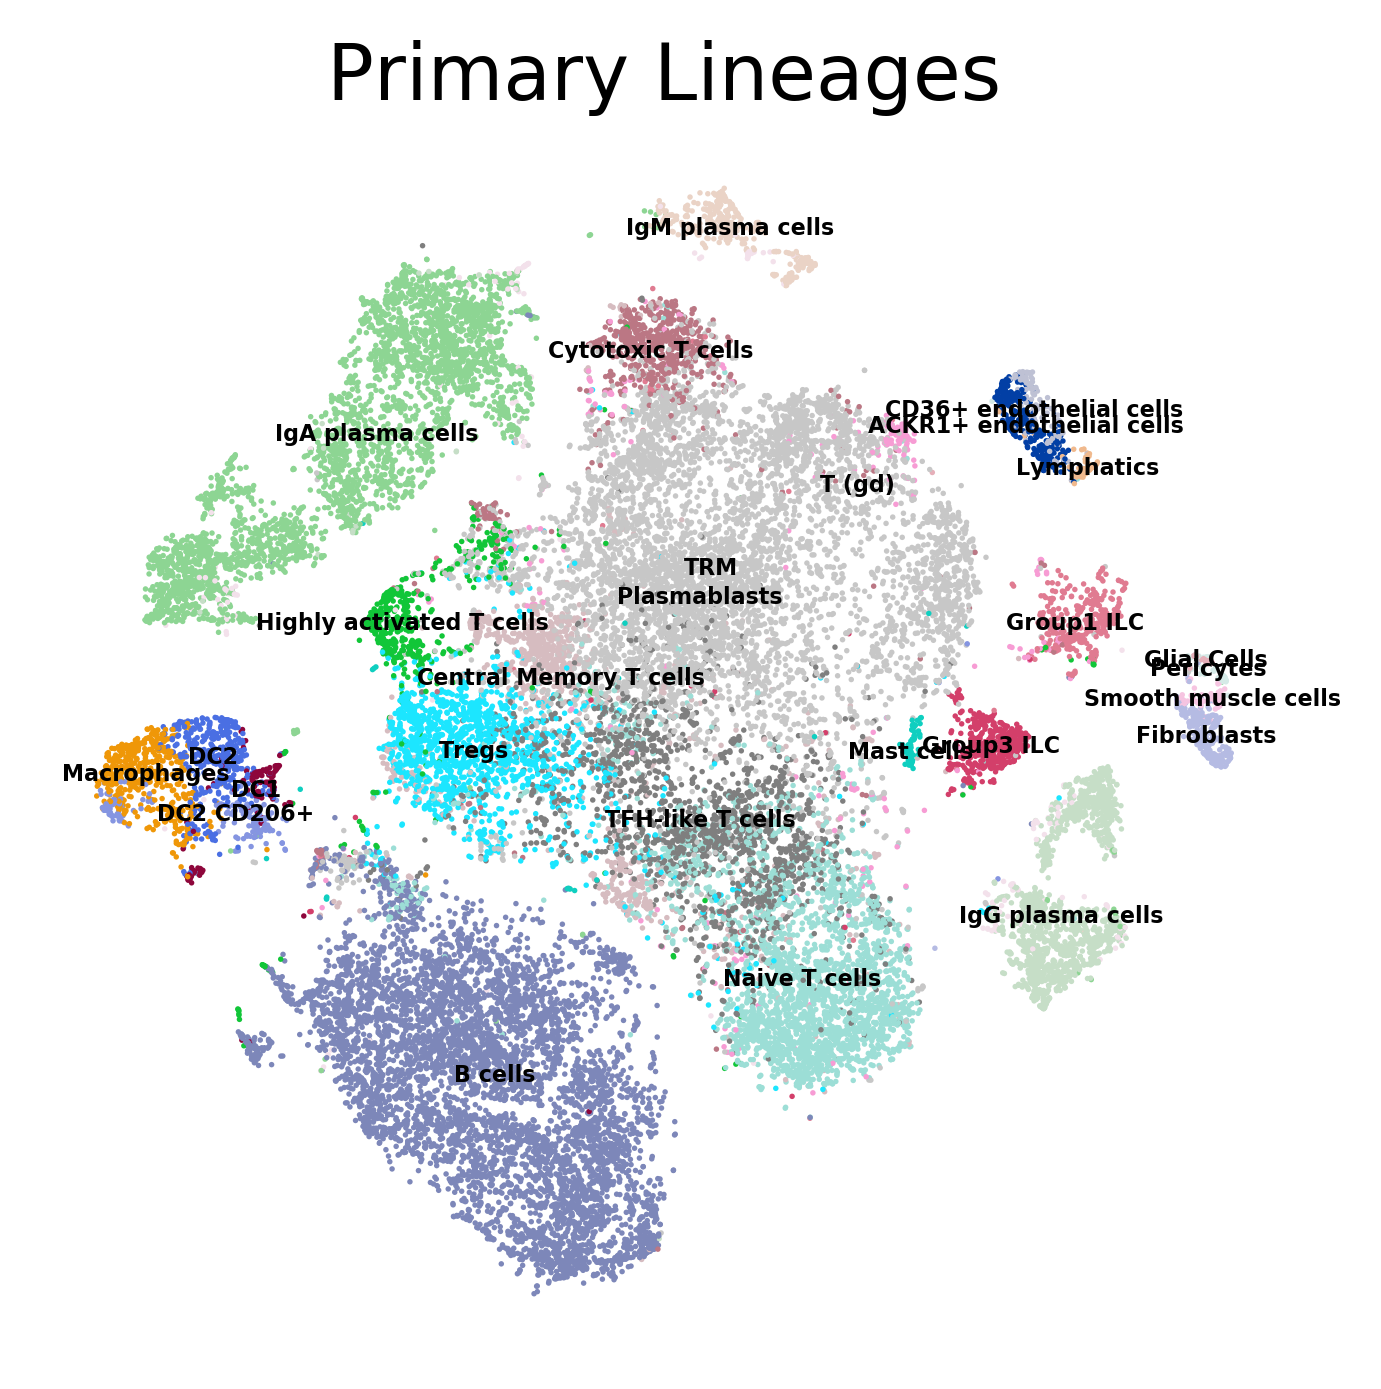

In [10]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.embedding(train_data, 'X_orig', color="Primary Lineages", frameon=False, ncols=2, legend_loc="on data", legend_fontsize=4)

Trying to set attribute `.obs` of view, copying.
... storing 'Primary Lineages' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


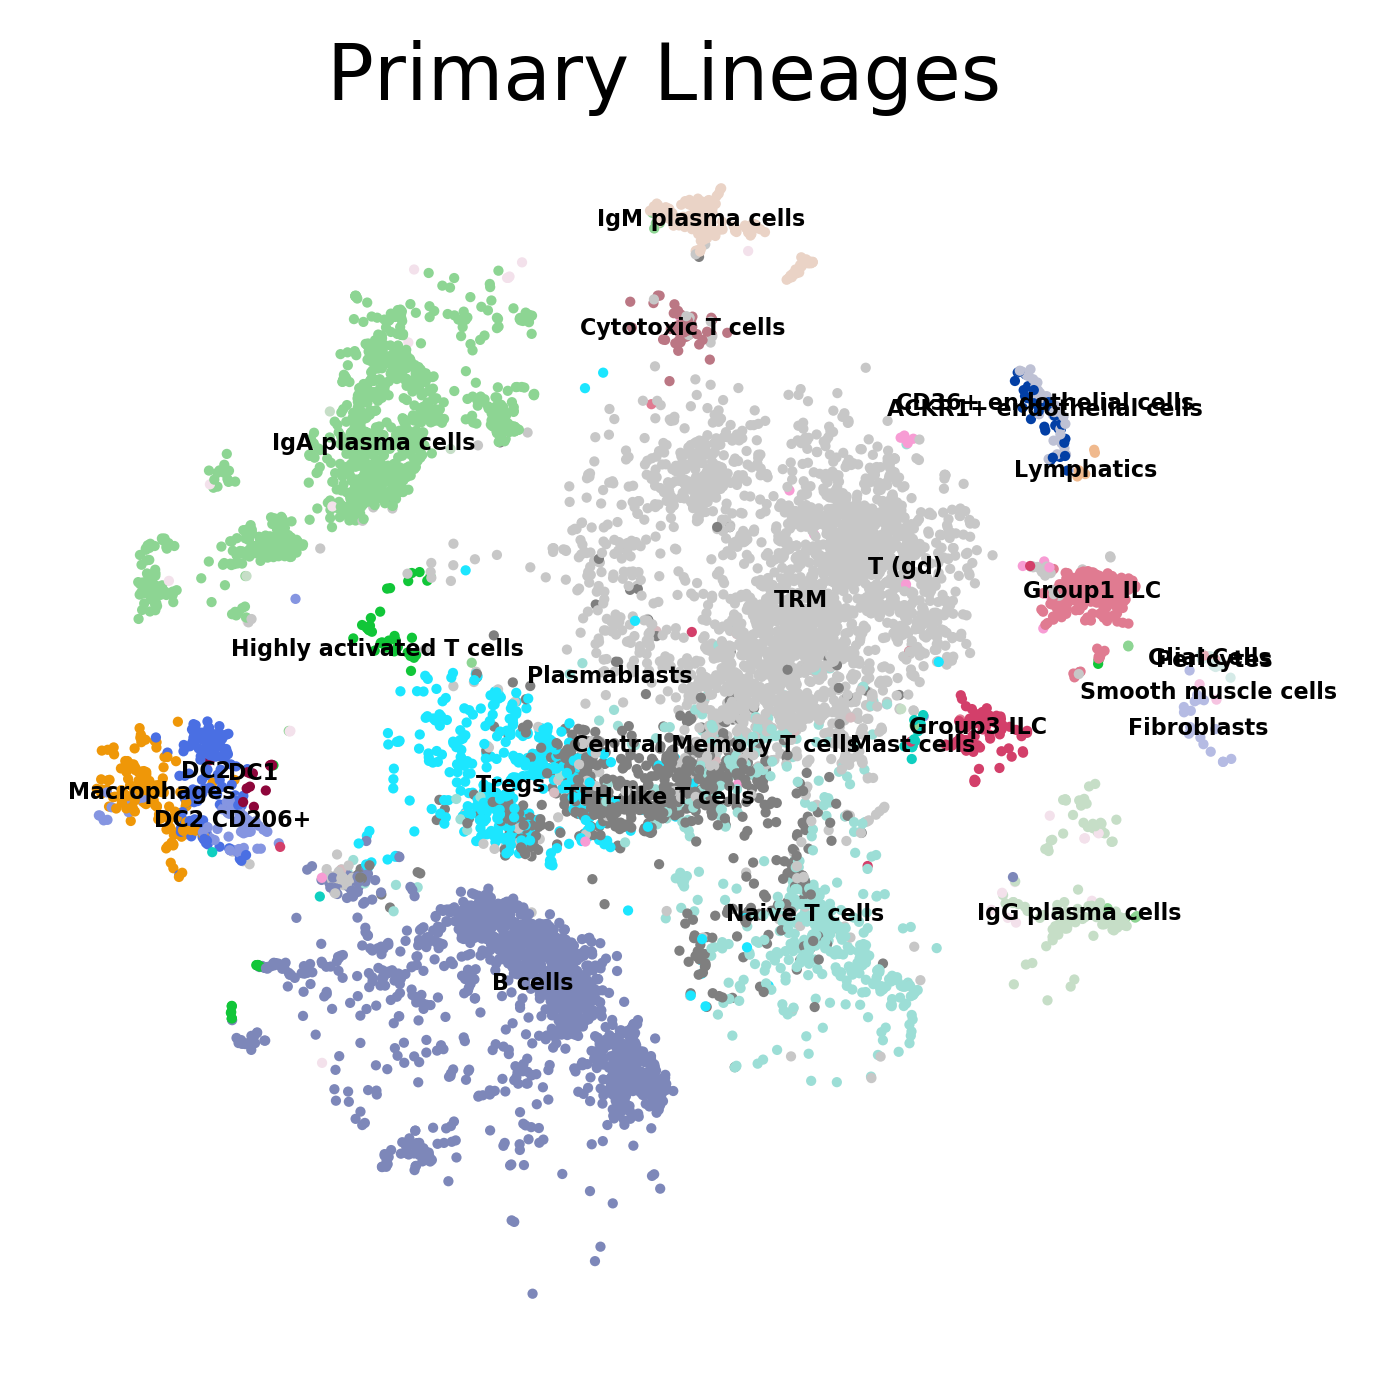

In [11]:
sc.pl.embedding(test_data, 'X_orig', color="Primary Lineages", frameon=False, ncols=2, legend_loc="on data", legend_fontsize=4)

In [12]:
def preproc(adata, hvg=None):
    adata.raw = adata
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    if hvg is None:
        sc.pp.highly_variable_genes(adata, n_top_genes=5000)
        # sc.pl.highly_variable_genes(adata)
        hvg = adata.var.highly_variable
    
    adata = adata[:, hvg]
    
    sc.pp.scale(adata, max_value=10)
    
    return adata
    
train_data = preproc(train_data)
test_data = preproc(test_data, train_data.var.index.to_list())

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [14]:
pca = PCA(100)
train_data.obsm['X_pca'] = pca.fit_transform(train_data.X)
test_data.obsm['X_pca'] = pca.transform(test_data.X)

In [15]:
lda = LinearDiscriminantAnalysis()
train_data.obsm['X_lda'] = lda.fit_transform(train_data.X, train_data.obs['Primary Lineages'])
test_data.obsm['X_lda'] = lda.transform(test_data.X)

## UMAP

computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


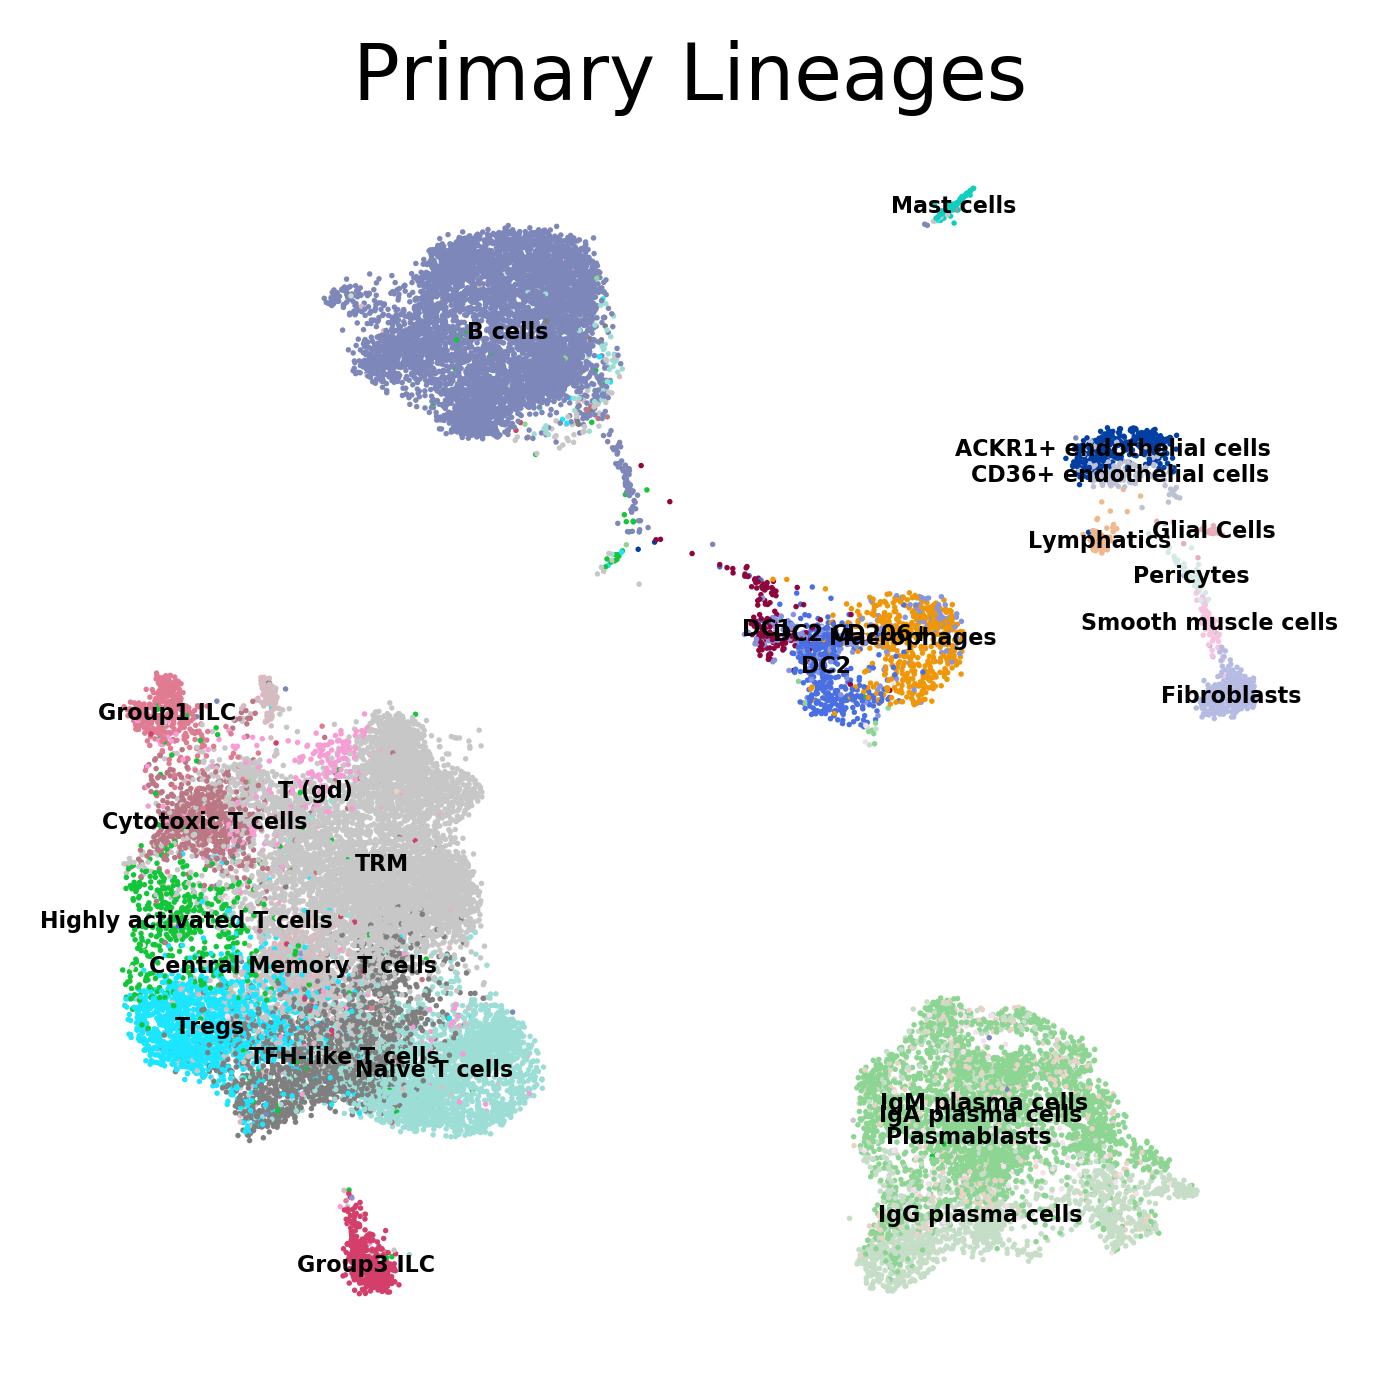

In [16]:
sc.pp.neighbors(train_data, n_neighbors=15, knn=True, random_state=0, method='umap')
sc.tl.umap(train_data)
sc.pl.umap(train_data, color="Primary Lineages", frameon=False, legend_loc="on data", legend_fontsize=4)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


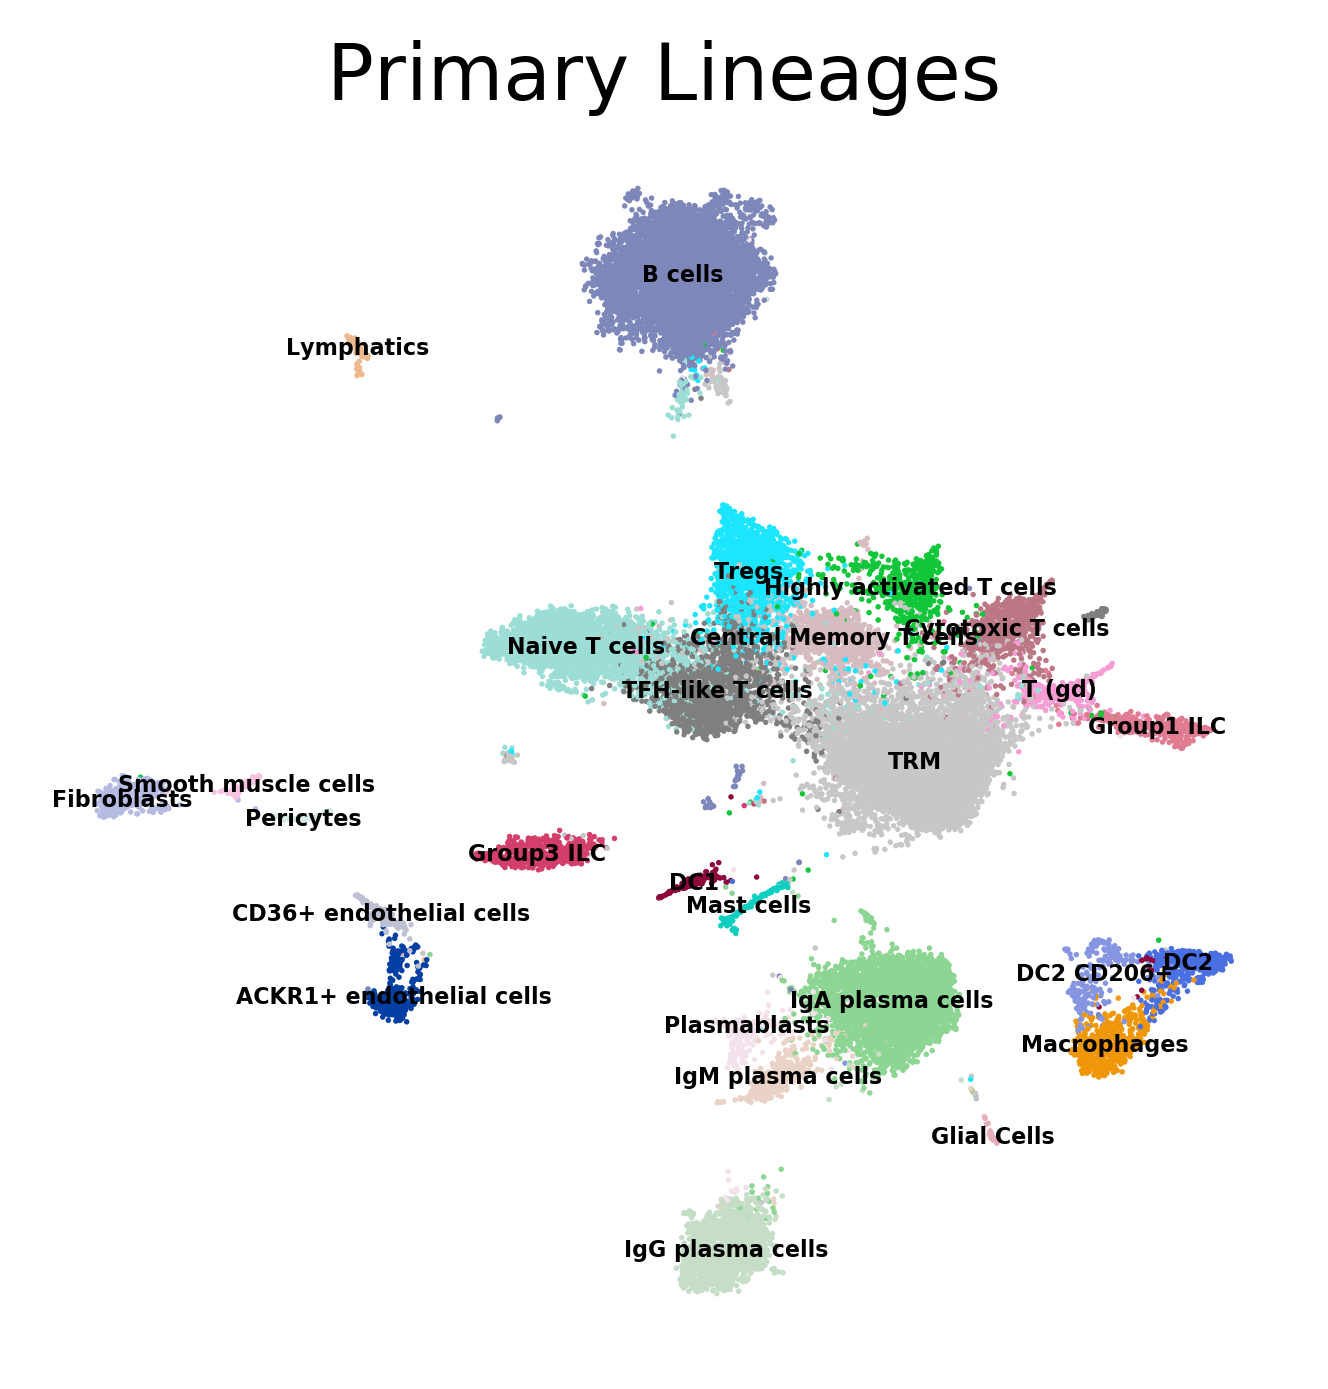

In [17]:
sc.pp.neighbors(train_data, n_neighbors=15, n_pcs=0, use_rep='X_lda', knn=True, random_state=0, method='umap')
sc.tl.umap(train_data)
sc.pl.umap(train_data, color="Primary Lineages", frameon=False, legend_loc="on data", legend_fontsize=4)

computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


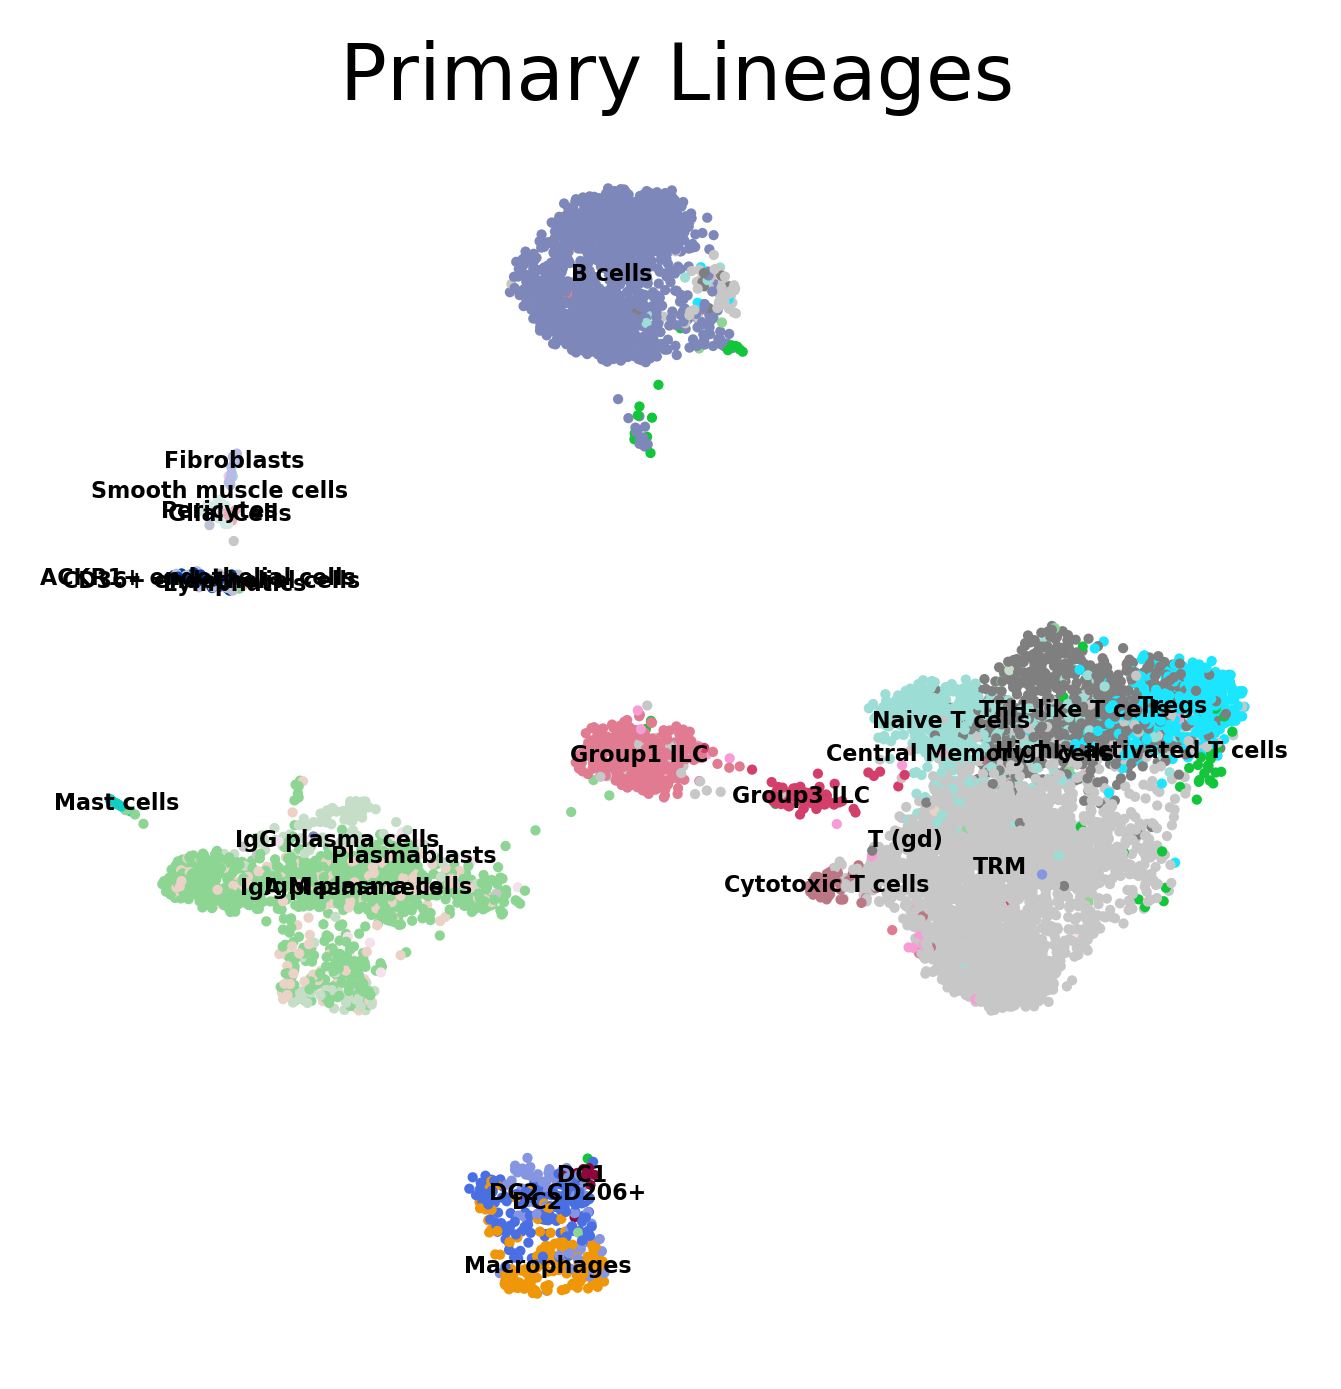

In [18]:
sc.pp.neighbors(test_data, n_neighbors=15, knn=True, random_state=0, method='umap')
sc.tl.umap(test_data)
sc.pl.umap(test_data, color="Primary Lineages", frameon=False, legend_loc="on data", legend_fontsize=4)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


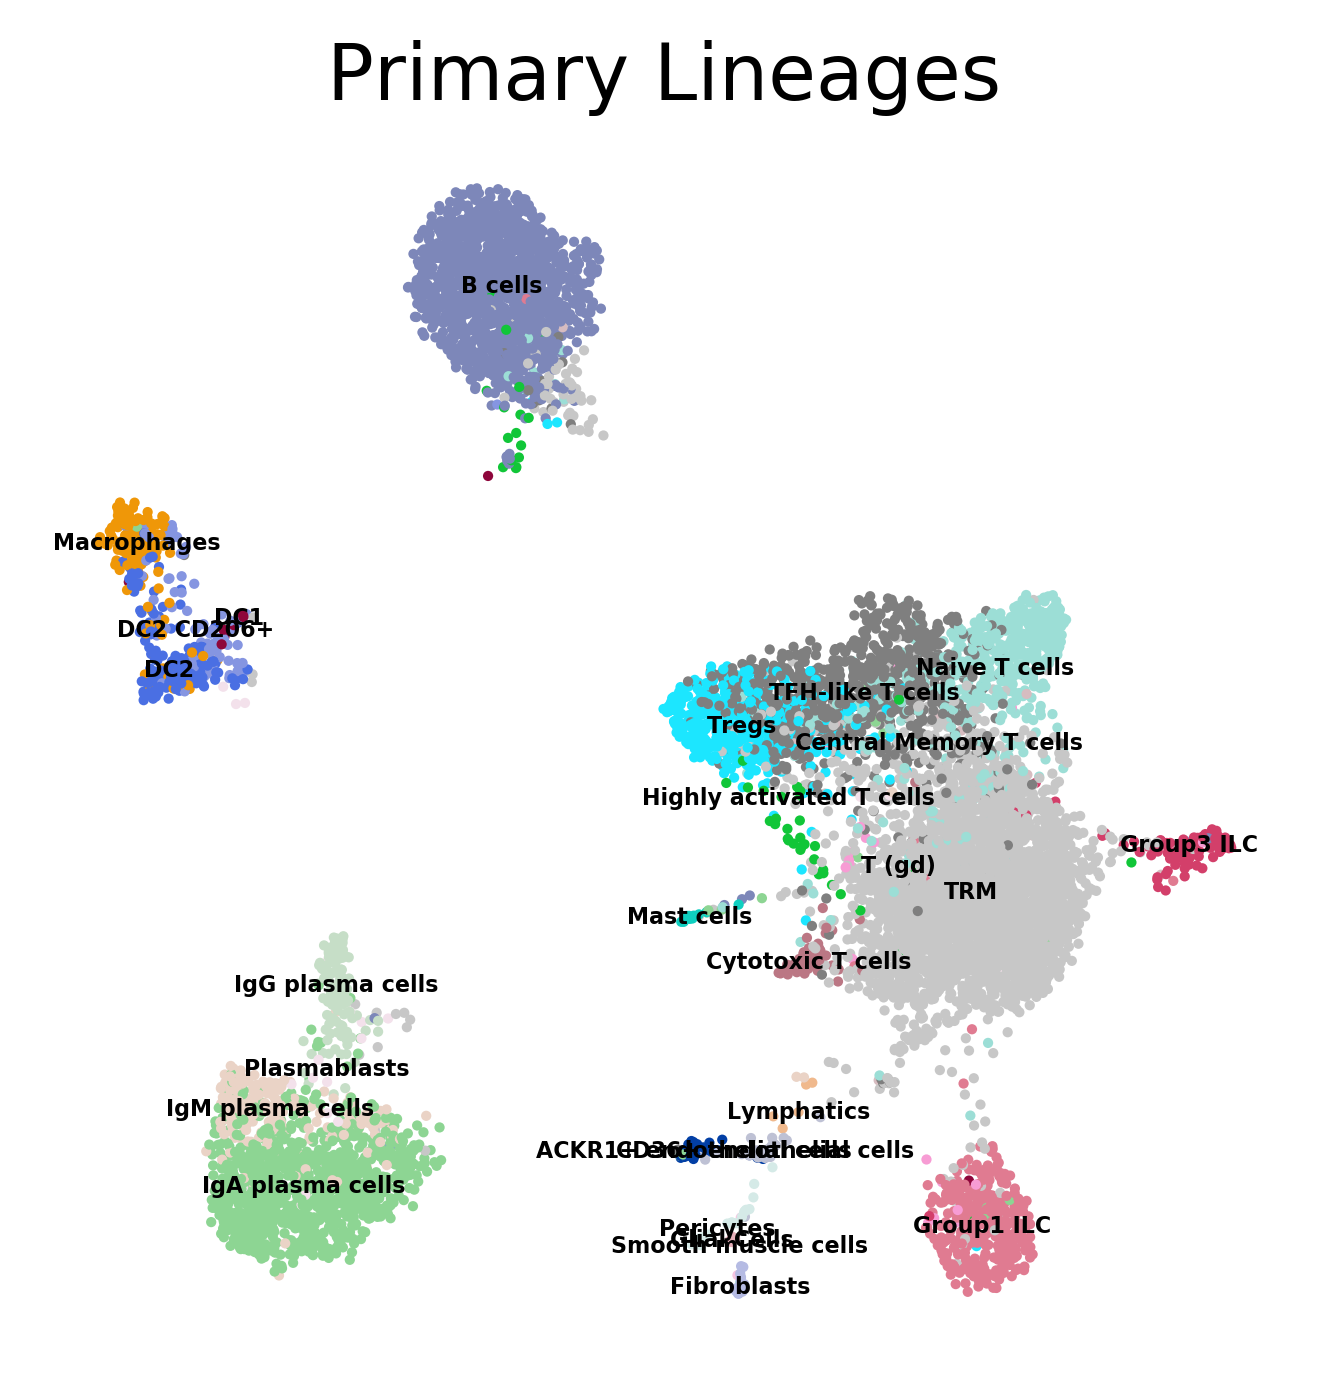

In [19]:
sc.pp.neighbors(test_data, n_neighbors=15, n_pcs=0, use_rep='X_lda', knn=True, random_state=0, method='umap')
sc.tl.umap(test_data)
sc.pl.umap(test_data, color="Primary Lineages", frameon=False, legend_loc="on data", legend_fontsize=4)

In [20]:
t_cell_subtypes = ["T (gd)", "TRM", "Cytotoxic T cells", "Highly activated T cells", "Central Memory T cells", "Tregs", 
                  "TFH like T cells", "Naive T cells"]
some_train_data = train_data[train_data.obs['Primary Lineages'].isin(t_cell_subtypes)]

In [21]:
some_train_data.obsm['X_lda'] = lda.fit_transform(train_data.X)

TypeError: fit() missing 1 required positional argument: 'y'